# 2 Data wrangling

## 2.2 Introduction

This step focuses on collecting your data, organizing it, and making sure it's well defined.

### 2.2.1 Recap Of Data Science Problem

The purpose of this data science project is to predict time to failure given each small segment of acoustic signal using a data-driven model

## 2.3 Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import numpy as np
import glob, os

## 2.4 Objectives

There are some fundamental questions to resolve in this notebook before you move on.

* Do you think you may have the data you need to tackle the desired question?
    * Have you identified the required target value?
    * Do you have potentially useful features?
* Do you have any fundamental issues with the data?
* Do your column names correspond to what those columns store?
    * Check the data types of your columns. Are they sensible?
    * Calculate summary statistics for each of your columns, such as mean, median, mode, standard deviation, range, and number of unique values. What does this tell you about your data? What do you now need to investigate?

# 2.5 Load the training data

## 2.5.1 Check a small section of data

In [2]:
filename = 'D:/DataScience/rawdata/2ndCapstone/train.csv'

In [3]:
df_tr_sec =  pd.read_csv(filename,nrows = 6e6)


In [4]:
df_tr_sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   acoustic_data    int64  
 1   time_to_failure  float64
dtypes: float64(1), int64(1)
memory usage: 91.6 MB


In [5]:
df_tr_sec.describe()

,acoustic_data,time_to_failure
count,6.000000e+06,6.000000e+06
mean,4.545660e+00,1.350958e+00
std,2.277303e+01,2.533610e+00
min,-4.621000e+03,7.954798e-04
25%,2.000000e+00,3.902964e-01
50%,5.000000e+00,7.796974e-01
75%,7.000000e+00,1.169098e+00
max,3.252000e+03,1.154080e+01


In [6]:
df_tr_sec.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


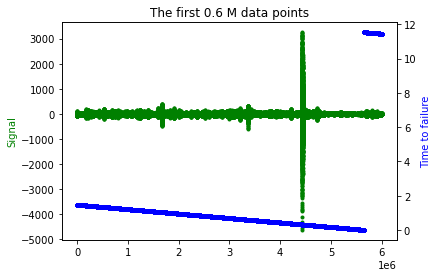

In [7]:
fig, ax1 = plt.subplots()
fig.figsize = (16,9)
ax2 = ax1.twinx()
ax1.plot(df_tr_sec['acoustic_data'], 'g.')
ax2.plot(df_tr_sec['time_to_failure'], 'b.')


ax1.set_ylabel('Signal', color='g')
ax2.set_ylabel('Time to failure', color='b')
plt.title('The first 0.6 M data points');

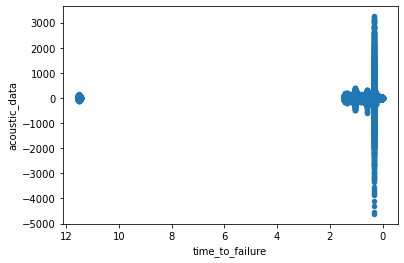

In [8]:
df_tr_sec.plot('time_to_failure','acoustic_data',kind = 'scatter')
plt.gca().invert_xaxis()

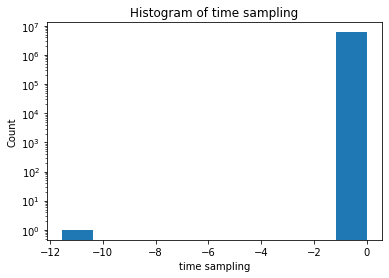

In [9]:
time2fail_np = df_tr_sec['time_to_failure'].to_numpy()
dt_np = time2fail_np[0:-1] - time2fail_np[1:] 
dt_unique_np= np.unique(dt_np)
# print("Unique time sampling:")
# print(dt_unique_np)
plt.hist(dt_np)
plt.title('Histogram of time sampling')
plt.ylabel('Count')
plt.yscale('log')
plt.xlabel('time sampling');

`acoustic_data` distribute unevenly.

From `time_to_failure`, the equipment may work a while to acquire signal at high frequency (1.1e-9 s), and then take a rest (1e-3 s)before next aquisition.

The sampling rate is not a constant



## 2.5.2 Truncate training data for each earthquake event

In [11]:
# using chunk to manipulate the raw train data
filenum = 0
j = 0
previous_df = pd.DataFrame()
total_missing = np.array([0,0])
total_records = 0
min_time = 100000

for chunk in pd.read_csv(filename, chunksize = 1e7):
    # count missing value in each column

    total_missing += chunk.isna().sum().to_numpy()
    total_records += len(chunk)
    min_time = np.array([chunk.iloc[-1,1], min_time]).min()
    
    j += 1
#     print('chunk', j)
    dt_df = chunk[['time_to_failure']].shift(fill_value = chunk.iloc[0]['time_to_failure']) - chunk[['time_to_failure']]
    # find the last index of an earthquake event
    idx = dt_df[dt_df['time_to_failure'] < 0].index
    
    if len(idx) == 0:
        previous_df = pd.concat([previous_df,chunk])
    else:
        prev_i = chunk.index[0]
#         print('idx', idx)
        for i in idx:
            # save each earthquake event in a pickle file
            pd.concat([previous_df, chunk.loc[prev_i:i, :]]).to_pickle('D:/DataScience/traindata/train_sec_' + str(filenum) + '.pkl')
            filenum += 1
            prev_i = i
        previous_df = chunk.loc[i:, :]
#     print('filename', filenum)

# The last earthquake file    
previous_df.to_pickle('D:/DataScience/traindata/train_sec_' + str(filenum) + '.pkl')

idx Int64Index([5656574], dtype='int64')
idx Int64Index([50085878], dtype='int64')
idx Int64Index([104677356], dtype='int64')
idx Int64Index([138772453], dtype='int64')
idx Int64Index([187641820], dtype='int64')
idx Int64Index([218652630], dtype='int64')
idx Int64Index([245829585], dtype='int64')
idx Int64Index([307838917], dtype='int64')
idx Int64Index([338276287], dtype='int64')
idx Int64Index([375377848], dtype='int64')
idx Int64Index([419368880], dtype='int64')
idx Int64Index([461811623], dtype='int64')
idx Int64Index([495800225], dtype='int64')
idx Int64Index([528777115], dtype='int64')
idx Int64Index([585568144], dtype='int64')
idx Int64Index([621985673], dtype='int64')


In [12]:
print("nan for two variables: ", total_missing)
print("Total records: ", total_records)
print("Last time of recording: ", min_time)

nan for two variables:  [0 0]
Total records:  629145480
Last time of recording:  0.021999835975000003


## 2.5.3 Check tuncated data

In [13]:
def plot_train_segment(fileobject):
    df = pd.read_pickle(fileobject)
    print(df.columns)
    print('Records number:',len(df))
    df.plot(x = 'time_to_failure', y = 'acoustic_data')
    
    plt.gca().invert_xaxis()
    plt.title(fileobject[31:-4])
    plt.savefig("../images/" + fileobject[25:-4] + ".jpg")
    #     plt.close()

In [14]:
pathlist = ['D:/DataScience/traindata/train_sec_' + str(num) + '.pkl' for num in range (0,17)]


Index(['acoustic_data', 'time_to_failure'], dtype='object')
Records number: 48869368
Index(['acoustic_data', 'time_to_failure'], dtype='object')
Records number: 31010811


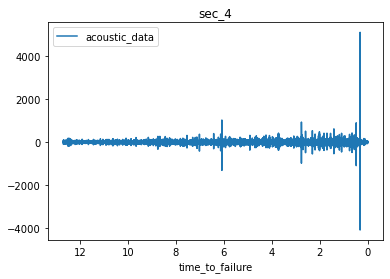

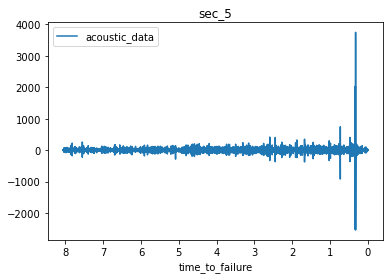

In [15]:
# plot the training segment and save figure
for path in pathlist[4:6]:
    plot_train_segment(path)

In [16]:
df_tr_end = pd.read_pickle(pathlist[-1])
df_tr_end.iloc[-5:]

,acoustic_data,time_to_failure
629145475,7,9.759796
629145476,9,9.759796
629145477,10,9.759796
629145478,6,9.759796
629145479,5,9.759796


`train_sec_16` is not complete, i.e., it does not records the failure event

## 2.5.4 Pandas profiling for a training segment

In [17]:
df_tr_sec = pd.read_pickle(pathlist[7])

In [18]:
profile = ProfileReport(df_tr_sec, title="Pandas Profiling Report of the Training Data 6")

In [19]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
profile.to_file("../report/training_data_report_6.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 2.6 Load the testing data

In [31]:
testfilepath = "../raw_data/test/"
os.chdir(testfilepath)
testfiles = glob.glob("*.csv")
print(testfiles[0:5])

['seg_00030f.csv', 'seg_0012b5.csv', 'seg_00184e.csv', 'seg_003339.csv', 'seg_0042cc.csv']


In [32]:
def plot_test_file(fileobject):
    df = pd.read_csv(fileobject)
    print(df.describe())
    df.plot(y = 'acoustic_data')
    plt.title(fileobject[0:-4])

In [33]:
df_te = pd.read_csv(testfiles[0])
df_te.head()

,acoustic_data
0,4
1,0
2,-2
3,0
4,2


14
       acoustic_data
count   150000.00000
mean         4.49178
std          4.89369
min        -75.00000
25%          2.00000
50%          4.00000
75%          7.00000
max        115.00000
14
       acoustic_data
count  150000.000000
mean        4.171153
std         5.922839
min      -140.000000
25%         2.000000
50%         4.000000
75%         7.000000
max       152.000000
14
       acoustic_data
count   150000.00000
mean         4.61026
std          6.94699
min       -193.00000
25%          2.00000
50%          5.00000
75%          7.00000
max        248.00000


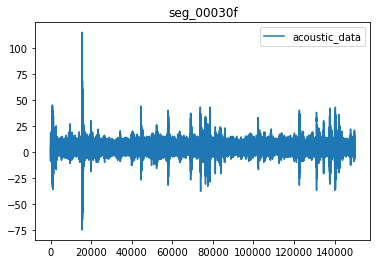

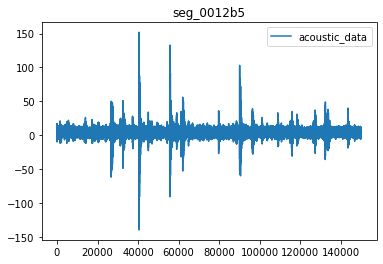

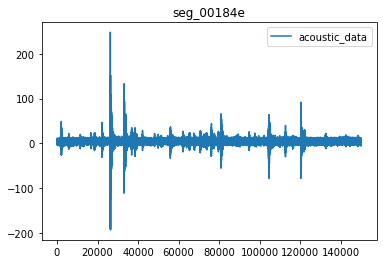

In [34]:
for testfile in testfiles[0:3]:
    print(len(testfile))
    plot_test_file(testfile)
    

# 2.7 Summary

For the training data:
* The data has zero missing values for both columns
* The data has only two column ,`acoustic_data` in int type and `time_to_failure` in float type. `time_to_failure` is our target.
* The data has 629,145,480 records, too large to operate.
* `acoustic_data` is the acoustic emission signal (amplitude), consisting of many peaks and troughts. 
* `time_to_failure` decreases from a value to zero periodically. The data should be truncated based on it.
* 17 segments were obtained after analyzing chunk data in the rawdata. 
* Each training segment has different time length
* The first one only has about two seconds record to earthquake. The last one is not complete because the `time_to_failure` is 9.75 s, far from zero.
* After `acoustic_data` reaches a extremly large event, the eqrthquake occurs soon in each training segment, and `time_to_failure` is less than 0.5s.

For the testing data:
* Only one row in each file, which is the `acoustic_data`
* Each segment contains 150k records, a small segment from a complete earthquake event. By comparision, records in training data is about 200 times of the test data. This may inspire us the feature extraction from the training data
* Similar to the training data, the average `acoustic_data` of a test data are small, while some abnormal `acoustic_data` exists. These determines what a feature is.
* Most test data may not contain the extremly large event with an absolute of amplitude over 1000. They contains peaks at a scale of several hundred amplitude